In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import imblearn.over_sampling as smote
warnings.filterwarnings("ignore", category=FutureWarning)

# ETL

In [121]:
df = pd.read_csv('fraude_bacario.csv')

In [122]:
#df.to_parquet("D:/bootcamp_experience/Bootcamp-machineLearning/fraude_bacario.parquet")

In [123]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [125]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [126]:
df.duplicated().sum()

0

Creando una nueva columna type2 conn las iniciales de 'nameOrig' y 'nameDest'

In [127]:
df['type2'] = df['nameOrig'].str[0] + df['nameDest'].str[0]
columna = df['type2']
del df['type2']
df.insert(2,'type2', columna) # se mueve la columna a la posicion 2 para tener mas orden
df.head()

,step,type,type2,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,CM,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,CM,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,CC,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,CC,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,CM,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Se eliminan columnas innecesarias

In [128]:
df.drop(columns=['nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'], inplace=True)

### Se verifica cuantos tipos de type y type2 hay

In [129]:
df['type'].value_counts().size

5

In [130]:
df['type2'].value_counts().size

2

In [131]:
df.head(3)

,step,type,type2,amount,isFraud
0,1,PAYMENT,CM,9839.64,0
1,1,PAYMENT,CM,1864.28,0
2,1,TRANSFER,CC,181.00,1


### Se convierte las columnans type y type2 en formato numerico, se van preparando los datos para el modelo de Machine Learning

In [132]:
df = pd.get_dummies(df, columns=['type', 'type2'],  dtype=int)

In [133]:
df.head()

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0
3,1,181.00,1,0,1,0,0,0,1,0
4,1,11668.14,0,0,0,0,1,0,0,1


# EDA
Se realiza un boxplot de las columnas: 'isFraud', 'amount', 'step'

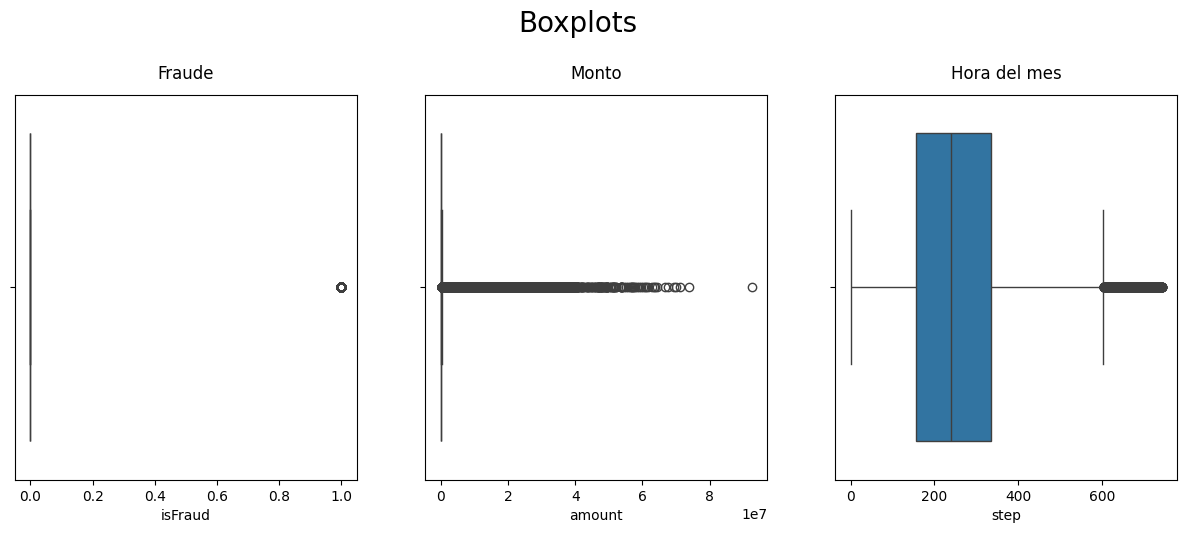

In [134]:
fig, axs = plt.subplots(1, 3, figsize= (15, 5))
fig.suptitle('Boxplots', fontsize=20, y=1.05)
sns.boxplot (x= 'isFraud', data = df, ax=axs[0]).set_title('Fraude', fontsize=12, y=1.02)
sns.boxplot (x= 'amount', data = df, ax=axs[1]).set_title('Monto', fontsize=12, y=1.02)
sns.boxplot (x= 'step', data = df, ax=axs[2]).set_title('Hora del mes', fontsize=12, y=1.02);


### Se crea una matriz de correlación

In [135]:
df.head()

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0
3,1,181.00,1,0,1,0,0,0,1,0
4,1,11668.14,0,0,0,0,1,0,0,1


In [136]:
matriz_correlacion = df.drop(columns='isFraud').corr()

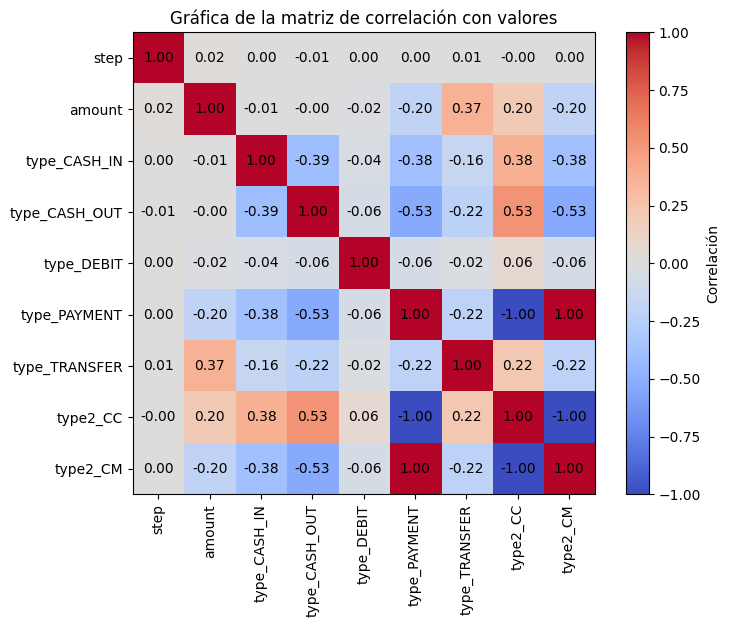

In [137]:
plt.figure(figsize=(8, 6))
plt.imshow(matriz_correlacion, cmap='coolwarm', interpolation='nearest')
plt.xticks(np.arange(len(matriz_correlacion.columns)), matriz_correlacion.columns, rotation=90)
plt.yticks(np.arange(len(matriz_correlacion.columns)), matriz_correlacion.columns)
plt.colorbar(label='Correlación')
plt.title('Gráfica de la matriz de correlación con valores')
for i in range(len(matriz_correlacion.columns)):
    for j in range(len(matriz_correlacion.columns)):
        plt.text(j, i, f'{matriz_correlacion.iloc[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

### Se verifica si esta balanceada la etiqueta objetivo

In [138]:
distribucion_isFraud = df['isFraud'].value_counts()
distribucion_isFraud

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [139]:
f'{round((8213/6354407)*100, 2)} %'

'0.13 %'

Como se observa solo el 0.13% de los datos de la etiqueta objetivo pertenecen a la categoria fraude, por lo tannto es necesario balancear los datos

Ahora observamos el desbalnaceo graficamente

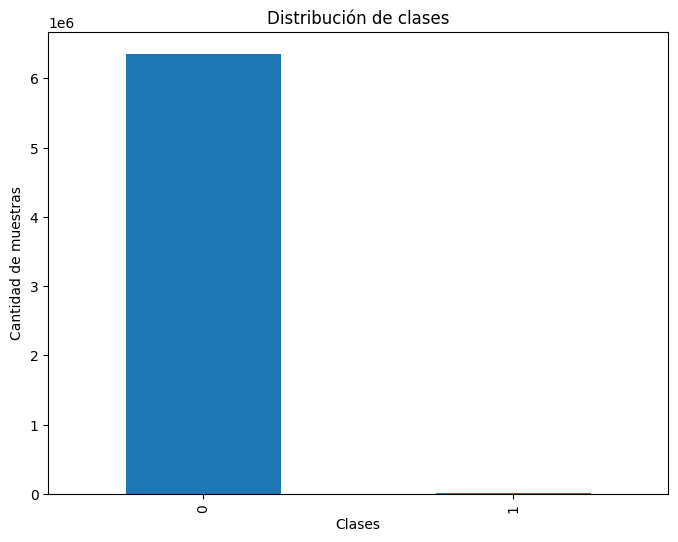

In [140]:
plt.figure(figsize=(8, 6))
distribucion_isFraud.plot(kind='bar')
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Cantidad de muestras');

### Balanceando la etiqueta objetivo

In [141]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter

In [142]:
df.head(3)

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0


In [143]:
# Separate features and target variable
X = df.drop("isFraud", axis=1)  # Assuming "isFraud" is the target column
y = df["isFraud"]

# Create the SMOTE object with appropriate parameters (adjust k as needed)
sm = smote.SMOTE(k_neighbors=5, random_state=42)

# Oversample the data using SMOTE
X_resampled, y_resampled = sm.fit_resample(X, y)

# Combine the resampled features and target variable
resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

# Print the shapes of original and resampled data to verify balancing
print("Original data shape:", df.shape)
print("Resampled data shape:", resampled_data.shape)

# Save the resampled data (optional)
resampled_data.to_csv("balanced_data.csv", index=False)





Original data shape: (6362620, 10)
Resampled data shape: (12708814, 10)
